# Continuous Control

The environment for this project is [Reacher](https://github.com/udacity/deep-reinforcement-learning/tree/master/p2_continuous_control) from Unity, and it's provided in the `setup` folder. We'll implement the A2C algorithm as the synchronous version of [A3C](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf) (but the input won't be directly from pixels). Results will be shown in this notebook and the best solution will be implemented in `main.py`.

![final](imgs/gif.gif "final")

> The model used to generate this gif is `final.pth` (Dueling Double DQN), which was trained for 700 episodes using `main.py`.

## 1. Prepare dependencies and environment

Take a look at README.md before executing this notebook and make sure that the kernel is set to **p2_continuous_control**.

In [1]:
!pip -q install ./setup

import sys
import platform

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal
from torch import nn

from setup import unityagents
from unityagents import UnityEnvironment

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Unity environments contain **brains**, our interfaces for controlling agents. We'll be conrtolling the first (default) brain in the environment. It's also useful to keep information such as `state_size`, `action_size` and `num_agents`.

In [2]:
env = None
system = platform.system()
if system == 'Linux':
    env = UnityEnvironment(file_name="setup/Reacher_Linux/Reacher.x86_64")
elif system == 'Darwin':
    env = UnityEnvironment(file_name="setup/Reacher.app")
elif system == 'Windows':
    env = UnityEnvironment(file_name="setup/Reacher_Windows_x86_64/Reacher.exe")
else:
    print('Cannot find environment for this system.')

# use the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## 2. Actor



In [3]:
class Actor(nn.Module):
    
    def __init__(self, state_size, action_size, hidden_layers=[64, 128, 64]):
        super(Actor, self).__init__()
        self.action_size = action_size
        
        # prepare the first hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        
        # prepare the rest of the hidden layers
        A = hidden_layers[:-1]
        B = hidden_layers[1:]
        self.hidden_layers.extend([nn.Linear(a, b) for a, b in zip(A, B)])
        
        # the actor will output the parameters of a normal distribution, 
        # so for each action we need mu and sigma^2 (thus we double the action size)
        self.output_layer = nn.Linear(hidden_layers[-1], action_size * 2)
        # self.std_layer = nn.Parameter(torch.zeros([1, action_size]))

    def forward(self, state):
        # connect layers to each other and put relu activations between them
        for layer in self.hidden_layers:
            state = layer(state)
            state = F.tanh(state)
        state = self.output_layer(state)  # [20, 8]
        # state = state.view(num_agents, 2, self.action_size)

        # reshape output in two rows (mu and sigma^2)
        
        mu = F.tanh(state[:, :self.action_size]).unsqueeze(1)  # [20, 1, 4]
        sigma = F.softplus(state[:, self.action_size:]).unsqueeze(1)  # [20, 1, 4]
        # sigma = F.softplus(self.std_layer)
        # mu is linear while sigma^2 uses a softplus
        distr_params = torch.cat((mu, sigma), dim=1)  # [20, 2, 4]
        
        return distr_params
    
    # -- some utility functions -- #

    def distributions(self, distr_params):
        # then construct a normal distribution that depends on these values
        return [Normal(d[0, :], d[1, :]) for d in distr_params]

    def act(self, distributions):
        # sample an action from a state's distribution
        
        # this policy is naturally stochastic, so there's no need to
        # force randomnes using a strategy like eps-greedy
        return np.clip(np.array([np.array(d.sample()) for d in distributions]), -1, 1)

    def log_prob(self, distr_params, actions):
        # distr_params  [n, num_agents, 2, num_actions]
        # actions       [n, num_agents, num_actions]

        # using a state's density function (pdf), calculate how likely it is to take the given action
        # advantage (to be defined) will determine whether this value will increase or decrease

        # for every step
        probs = torch.empty([0]).to(device)
        for step_d_params, step_a in zip(distr_params, actions):
            # step_d_params                               [num_agents, 2, num_actions]
            # step_a                                      [num_agents, num_actions]
            step_d = self.distributions(step_d_params)  # list of num_agents Normal()

            # for every agent calculate the log_prob of the action taken
            step_probs = torch.empty([0]).to(device)
            for d, a in zip(step_d, step_a):
                # d                                    Normal()
                # a                                    [num_actions]
                prob = d.log_prob(a)                 # [num_actions]
                prob = torch.sum(prob).unsqueeze(0)  # [1], the likelihood of a under d
                step_probs = torch.cat((step_probs, prob))
            
            step_probs = step_probs.unsqueeze(0)  # [1, num_agents]
            probs = torch.cat((probs, step_probs))

        return probs  # [n, num_agents]
    
    def entropy(self, distr_params):
        # distr_params  [n, num_agents, 2, num_actions]

        # calculate the entropy of a state's distribution (in other words, how uncertain the 
        # result is -- which only depends on sigma in the case of a normal distribution)

        # this will be maximized so that some exploration is always encouraged

        # for every step
        entropies = torch.empty([0]).to(device)
        for step_d_params in distr_params:
            # step_d_params                               [num_agents, 2, num_actions]
            step_d = self.distributions(step_d_params)  # list of num_agents Normal()

            # for every agent calculate the entropy of the distribution used to take the action
            step_entr = torch.empty([0]).to(device)
            for d in step_d:
                # d                                    Normal()
                entr = d.entropy()                   # [num_actions]
                entr = torch.sum(entr).unsqueeze(0)  # [1], how uncertain d is
                step_entr = torch.cat((step_entr, entr))
            
            step_entr = step_entr.unsqueeze(0)  # [1, num_agents]
            entropies = torch.cat((entropies, step_entr))

        return entropies  # [n, num_agents]
        

## 3. Critic


In [4]:
class Critic(nn.Module):
    
    def __init__(self, state_size, hidden_layers=[64, 128, 64]):
        super(Critic, self).__init__()
        
        # prepare the first hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        
        # prepare the rest of the hidden layers
        A = hidden_layers[:-1]
        B = hidden_layers[1:]
        self.hidden_layers.extend([nn.Linear(a, b) for a, b in zip(A, B)])
        
        # the critic outputs only a scalar V(s)
        self.output_layer = nn.Linear(hidden_layers[-1], 1)

    def forward(self, state):
        # connect layers to each other and put relu activations between them
        for layer in self.hidden_layers:
            state = layer(state)
            state = F.tanh(state)
        state = self.output_layer(state)
        return state

## 4. Advantage Estimation

### 4.1 $n$-step

In [5]:
def n_step(rewards, returns, values, gamma, tau):
    return (returns[:-1] - values[:-1]).detach()

### 4.2 GAE

In [6]:
def gae(rewards, returns, values, gamma, tau):
    print(rewards.size(), values[1:].size(), values[:-1].size())
    one_step_advantage = np.array(rewards + gamma * values[1:] -  values[:-1])
    print(one_step_advantage)
    advantage = 0
    advantages = []
    for step in one_step_advantage[::-1]:
        advantage = step + gamma * tau * advantage
        advantages.append(advantage)
    return torch.FloatTensor(advantage[::-1]).detach().to(device)


## 5. Agent

In [7]:
class A2CAgent():
    
    # -- initialization -- #
    def __init__(self, state_size, action_size, calc_advantage, 
                 gamma=0.99, alpha_actor=0.001, alpha_critic=0.001, beta=0.001, tau=0.25,
                 n=4, learning=True):
        self.state_size, self.action_size = state_size, action_size
        self.calc_advantage = calc_advantage
        self.learning = learning
        self.alpha_actor, self.alpha_critic = alpha_actor, alpha_critic
        self.gamma, self.tau = gamma, tau
        self.beta = beta
        self.n = n
        self.reset()

    def reset_temporary_buffer(self):
        # used to store n consecutive steps
        self.tmp_s, self.tmp_a, self.tmp_r, self.tmp_ns, self.tmp_d = \
            ([None] * self.n, [None] * self.n, [None] * self.n, [None] * self.n, [None] * self.n)
        self.tmp_actor_out = [None] * self.n
    
    def reset(self):
        self.actor = Actor(state_size, action_size).to(device)
        self.critic = Critic(state_size).to(device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.alpha_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.alpha_critic)
        
        self.reset_temporary_buffer()
        self.i = 0
    # -- initialization -- #

    def act(self, s):
        
        # use the actor to transform the state into a normal distribution
        s = torch.FloatTensor(s).to(device)
        distr_params = self.actor(s)
        distributions = self.actor.distributions(distr_params)

        # store the distribution as we'll need it later
        # self.tmp_actor_out[self.i] = distr_params
        self.tmp_actor_out[self.i] = distr_params.unsqueeze(0)

        # sample an action from the distribution
        return self.actor.act(distributions)

    def store(self, s, a, r, ns, d):
        self.tmp_s[self.i], self.tmp_a[self.i], self.tmp_r[self.i], self.tmp_ns[self.i], self.tmp_d[self.i] = (s, a, r, ns, d)

        if self.i == self.n - 1:
            self.learn()
        
        self.i = (self.i + 1) % self.n

    def learn(self):

        s, a, r, ns, d, actor_out = (
            torch.FloatTensor(self.tmp_s).to(device),        # [n, num_agents, state_size]
            torch.FloatTensor(self.tmp_a).to(device),        # [n, num_agents, action_size]
            torch.FloatTensor(self.tmp_r).to(device),        # [n, num_agents]
            torch.FloatTensor(self.tmp_ns).to(device),       # [n, num_agents, state_size]
            torch.FloatTensor(self.tmp_d).to(device),        # [n, num_agents]
            torch.cat(self.tmp_actor_out, dim=0).to(device)  # [n, num_agents, 2, action_size]
        )

        # use the critic to evaluate all n+1 states
        last_states = ns[-1:]                               # [1, agents, state_size]
        all_states = torch.cat((s, last_states), dim=0)     # [n+1, num_agents, state_size]
        state_values = self.critic(all_states).squeeze(2)   # [n+1, num_agents]
        pad_d = torch.cat((torch.zeros(1, num_agents).to(device), d))  # [n+1, num_agents]
        
        # g_n+1, which should be zero if the episode is ended
        last_values = state_values[-1:].detach()  # [1, num_agents]
        last_values *= (1 - pad_d[-1:])           # [1, num_agents]

        # r_1, r_2, ..., r_n, g_n+1
        # tmp_rewards = torch.cat((self.r, last_predicted_returns), dim=0)  # [n+1, num_agents]

        # calculate some slightly more accurate returns using n rewards and a predicion of G_n+1
        # note that the prediction will only be considered if the episode isn't finished yet        
        returns = last_values
        for reward in r:
            tmp = (reward + self.gamma * returns[0]).unsqueeze(0)  # [1, num_agents]
            returns = torch.cat((tmp, returns), dim=0)
        # returns [n+1, num_agents]

        # calculate the advantages at each state
        advantages = self.calc_advantage(r, returns, state_values * (1 - pad_d), self.gamma, self.tau)
        # print(advantages)
        # advantages = torch.clamp(advantages, -1, 1).squeeze(1)
        # advantages = self.calc_advantage(self.r, returns, state_values, self.gamma, self.tau)

        # actor update
        self.actor_optimizer.zero_grad()
        log_prob = -self.actor.log_prob(actor_out, a.detach())
        entropy = self.actor.entropy(actor_out)
        actor_loss = torch.mean(log_prob * advantages + entropy * self.beta)
        actor_loss.backward()
        nn.utils.clip_grad_norm(self.actor.parameters(), 1)

        self.actor_optimizer.step()

        # critic update
        self.critic_optimizer.zero_grad()
        critic_loss = torch.mean((returns[:-1].detach() - state_values[:-1]) ** 2)
        critic_loss.backward()
        nn.utils.clip_grad_norm(self.critic.parameters(), 1)
        self.critic_optimizer.step()

        self.reset_temporary_buffer()
        

## 6. Training an agent

In [8]:
agents = [('A2Cn4', A2CAgent(state_size, action_size, n_step, n=4))]
          # ('A2Cn8', A2CAgent(state_size, action_size, n_step, n=8)),
          # ('A2CGAEn8', A2CAgent(state_size, action_size, gae, n=8))]

In [9]:
def execute_episode(agent, env):
    # prepare the environment
    scores = np.zeros(num_agents)
    env_info = env.reset(train_mode=True)[brain_name]
    
    # get the initial state
    states = env_info.vector_observations
    while True:

        # evaluate the current state
        actions = agent.act(states)
        if np.isnan(actions).any():
            raise SystemExit("Stop right there!")
        # print(actions)

        # execute the chosen action and get the outcome
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done

        # store the experience (also automatically learn, from time to time)
        agent.store(states, actions, rewards, next_states, dones)

        # prepare for the next iteration
        states = next_states
        scores += rewards

        if np.any(dones):
            break
    
    # return the total rewards obtained
    return np.mean(scores)

In [10]:
def train(agent, env, episodes=200, repeat=1, consecutive_episodes=100, show_output=True, save_as=None):

    results = [None] * repeat
    for r in range(repeat):
        partial_results = [None] * episodes

        # reset the agent to start learning from scratch
        # agent.reset()
        for i in range(episodes):

            # execute all the episodes and store the results
            score = execute_episode(agent, env)
            partial_results[i] = score
            
            if show_output:
                print("\r[{}] Episode: {}, Score: {}".format(r+1, i+1, score), end="")
                sys.stdout.flush()
        if show_output:
            print()

        results[r] = partial_results

        # store the trained model if requested
        if save_as is not None:
            torch.save(agent.actor.state_dict(), '{}/{}_actor.pth'.format(save_as, r+1))
            torch.save(agent.critic.state_dict(), '{}/{}_critic.pth'.format(save_as, r+1))

    # use convolutions to calculate the mean and standard deviation summarizing the training step
    results = np.array(results)
    mean = signal.convolve2d(results, np.ones([repeat, consecutive_episodes]) / (repeat * consecutive_episodes), mode='valid')    
    v = signal.convolve2d(results, np.ones([1, consecutive_episodes]) / consecutive_episodes, mode='valid')
    std_dev = signal.convolve2d(v ** 2 - mean ** 2, np.ones([repeat, 1]) / repeat, mode='valid') ** (1/2)
    return mean.flatten(), std_dev.flatten(), results

In [11]:
training_results = []
for ag in agents:
    name, agent = ag
    print('Agent: {}'.format(name))
    mean, std_dev, full_report = train(agent, env, save_as='models/{}'.format(name.replace(" ", "_")))
    training_results.append((mean, std_dev, full_report))
# env.close()

Agent: A2Cn4
[1] Episode: 80, Score: 0.47549998937174676

SystemExit: Stop right there!

## 7. Comparing the results

A2Cn4: Solved after 100 episodes


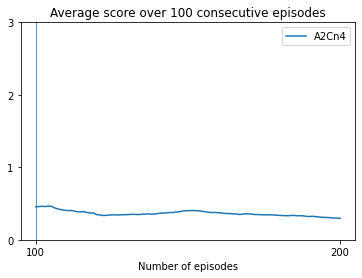

In [12]:
def plot_results(agents, training_results):
    for agent, ts in zip(agents, training_results):
        mean, std_dev, _ = ts
        episode_solved = np.argmax(mean > 30) + 100
        print('{}: Solved after {} episodes'.format(agent[0], episode_solved))

        x = np.arange(100, 100 + mean.size)
        line = plt.plot(x, mean, label = agent[0])
        plt.fill_between(x, mean + std_dev, mean - std_dev, alpha=0.25)
        plt.axvline(episode_solved, lw=0.75, color=line[0].get_color())

    # plt.axhline(30, dashes=(4, 8), lw=0.75, color='black')
    plt.xticks(np.arange(1, 1 + mean.size / 100) * 100)
    plt.yticks(np.arange(0, 4))
    plt.xlabel('Number of episodes')
    plt.title('Average score over 100 consecutive episodes')
    plt.legend()
    plt.show()

plot_results(agents[:1], training_results[:1])
# plot_results(agents[2:], training_results[2:])

## 8. Possible improvements

## 9. Conclusions